In [223]:
import cv2 as cv
import numpy as np
import imageio
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug import parameters as iap
%matplotlib inline

### Load and display an test image 

Original: (128, 96, 4)


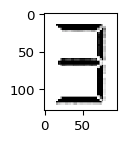

In [224]:
image = imageio.imread("./digit/3.png")
image = cv2.resize(image, (96,128), interpolation=cv2.INTER_CUBIC)
print("Original:", image.shape)
ia.imshow(image)

### Affine Rotation of a batch of images

Augmented batch:
Number of image in batch:  4


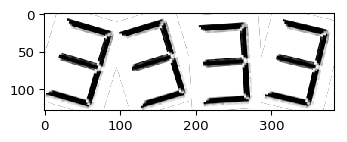

In [240]:
images = [image, image, image, image]
images_aug = rotate.augment_images(images)

print("Augmented batch:")
print("Number of image in batch: ", len(images))
ia.imshow(np.hstack(images_aug))

### Combine a sequence of augmentation 

Augmented sequence:


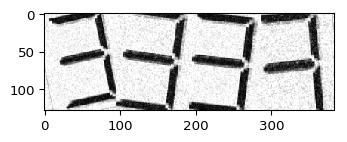

In [227]:
seq = iaa.Sequential([
    iaa.Affine(rotate=(-25, 25)),
    iaa.AdditiveGaussianNoise(scale=(10, 60)),
    iaa.Crop(percent=(0, 0.2))
])

images_aug = seq.augment_images(images)

print("Augmented sequence:")
ia.imshow(np.hstack(images_aug))

### Loop over the random order seq

Loop over seq by random ordered augmented:


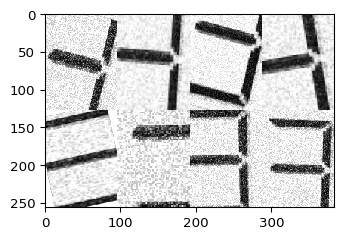

In [228]:
seq = iaa.Sequential([
    iaa.Affine(rotate=(-25, 25)),
    iaa.AdditiveGaussianNoise(scale=(30, 90)),
    iaa.Crop(percent=(0, 0.4))
], random_order=True)

images_aug = [seq.augment_image(image) for _ in range(8)]

print("Loop over seq by random ordered augmented:")
ia.imshow(ia.draw_grid(images_aug, cols=4, rows=2))

### Stochastic (default) and Deterministic (unchanged) Modes

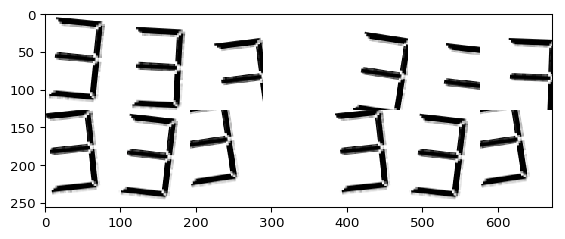

In [230]:
aug = iaa.Affine(translate_px=(-30, 30), rotate=(-10, 10), cval=255)
batches = [[image] * 3, [image] * 3]  # two batches of each three images


# augment in stochastic mode
images_stochastic = [aug.augment_images(batch) for batch in batches]

# augment in deterministic mode
aug_det = aug.to_deterministic()
images_deterministic = [aug_det.augment_images(batch) for batch in batches]

# visualize
whitespace = np.full(image.shape, 255, dtype=np.uint8)
ia.imshow(
    ia.draw_grid(
        images_stochastic[0] + [whitespace] + images_stochastic[1] +  # first row is stochastic mode
        images_deterministic[0] + [whitespace] + images_deterministic[1],  # second row is deterministic mode
        rows=2,
        cols=2*3
    )
)

### Apply salt and pepper noise 

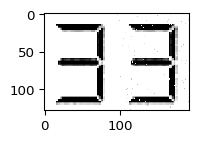

In [231]:
def apply_coarse_salt_and_pepper(image, p, size_px):
    # mask where to replace
    mask = iap.Binomial(p)
    
    # make the mask coarser
    mask_coarse = iap.FromLowerResolution(other_param=mask, size_px=size_px)

    # the noise to use as replacements, mostly close to 0.0 and 1.0
    replacement = iap.Beta(0.5, 0.5)
    
    # project noise to uint8 value range
    replacement = replacement * 255

    # replace masked areas with noise
    return iaa.ReplaceElementwise(
        mask=mask_coarse,
        replacement=replacement
    ).augment_image(image)


image_aug = apply_coarse_salt_and_pepper(image, 0.02, 100)  # apply noise
ia.imshow(
    ia.imresize_single_image(
        np.hstack([image, image_aug]),
        1.0
    )
)

### A simple and common augmentation sequence

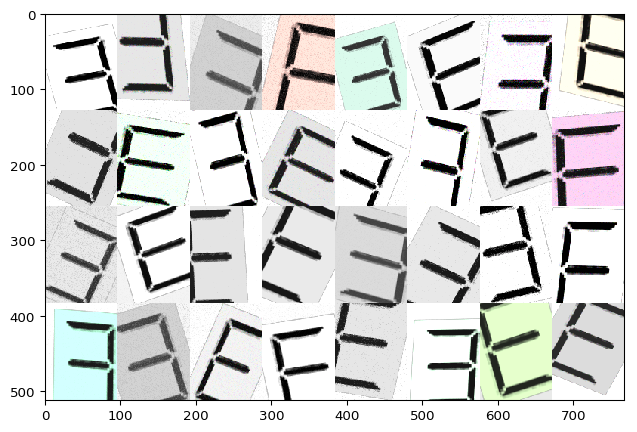

In [232]:
ia.seed(1)

# Example batch of images.
# The array has shape (32, 64, 64, 3) and dtype uint8.
images = np.array(
    [image for _ in range(32)],
    dtype=np.uint8
)

#ia.imshow(ia.draw_grid(images, cols=8, rows=4))

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.1*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

images_aug = seq(images=images)
ia.imshow(ia.draw_grid(images_aug, cols=8, rows=4))

### A heavy augmentation example

In [233]:
ia.seed(1)

# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second
# image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image.
seq = iaa.Sequential(
    [
        #
        # Apply the following augmenters to most images.
        #
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images

        # crop some of the images by 0-10% of their height/width
        sometimes(iaa.Crop(percent=(0, 0.1))),

        # Apply affine transformations to some of the images
        # - scale to 80-120% of image height/width (each axis independently)
        # - translate by -20 to +20 relative to height/width (per axis)
        # - rotate by -45 to +45 degrees
        # - shear by -16 to +16 degrees
        # - order: use nearest neighbour or bilinear interpolation (fast)
        # - mode: use any available mode to fill newly created pixels
        #         see API or scikit-image for which modes are available
        # - cval: if the mode is constant, then use a random brightness
        #         for the newly created pixels (e.g. sometimes black,
        #         sometimes white)
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-45, 45),
            shear=(-16, 16),
            order=[0, 1],
            cval=(0, 255),
            mode=ia.ALL
        )),

        #
        # Execute 0 to 5 of the following (less important) augmenters per
        # image. Don't execute all of them, as that would often be way too
        # strong.
        #
        iaa.SomeOf((0, 5),
            [
                # Convert some images into their superpixel representation,
                # sample between 20 and 200 superpixels per image, but do
                # not replace all superpixels with their average, only
                # some of them (p_replace).
                sometimes(
                    iaa.Superpixels(
                        p_replace=(0, 1.0),
                        n_segments=(20, 200)
                    )
                ),

                # Blur each image with varying strength using
                # gaussian blur (sigma between 0 and 3.0),
                # average/uniform blur (kernel size between 2x2 and 7x7)
                # median blur (kernel size between 3x3 and 11x11).
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)),
                    iaa.AverageBlur(k=(2, 7)),
                    iaa.MedianBlur(k=(3, 11)),
                ]),

                # Sharpen each image, overlay the result with the original
                # image using an alpha between 0 (no sharpening) and 1
                # (full sharpening effect).
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),

                # Same as sharpen, but for an embossing effect.
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),

                # Search in some images either for all edges or for
                # directed edges. These edges are then marked in a black
                # and white image and overlayed with the original image
                # using an alpha of 0 to 0.7.
                sometimes(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0, 0.7)),
                    iaa.DirectedEdgeDetect(
                        alpha=(0, 0.7), direction=(0.0, 1.0)
                    ),
                ])),

                # Add gaussian noise to some images.
                # In 50% of these cases, the noise is randomly sampled per
                # channel and pixel.
                # In the other 50% of all cases it is sampled once per
                # pixel (i.e. brightness change).
                iaa.AdditiveGaussianNoise(
                    loc=0, scale=(0.0, 0.05*255), per_channel=0.5
                ),

                # Either drop randomly 1 to 10% of all pixels (i.e. set
                # them to black) or drop them on an image with 2-5% percent
                # of the original size, leading to large dropped
                # rectangles.
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5),
                    iaa.CoarseDropout(
                        (0.03, 0.15), size_percent=(0.02, 0.05),
                        per_channel=0.2
                    ),
                ]),

                # Invert each image's channel with 5% probability.
                # This sets each pixel value v to 255-v.
                iaa.Invert(0.05, per_channel=True), # invert color channels

                # Add a value of -10 to 10 to each pixel.
                iaa.Add((-10, 10), per_channel=0.5),

                # Change brightness of images (50-150% of original value).
                iaa.Multiply((0.5, 1.5), per_channel=0.5),

                # Improve or worsen the contrast of images.
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),

                # Convert each image to grayscale and then overlay the
                # result with the original with random alpha. I.e. remove
                # colors with varying strengths.
                iaa.Grayscale(alpha=(0.0, 1.0)),

                # In some images move pixels locally around (with random
                # strengths).
                sometimes(
                    iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)
                ),

                # In some images distort local areas with varying strength.
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05)))
            ],
            # do all of the above augmentations in random order
            random_order=True
        )
    ],
    # do all of the above augmentations in random order
    random_order=True
)

images_aug = seq(images=images)
ia.imshow(ia.draw_grid(images_aug, cols=8, rows=4))

AssertionError: 

### Blending/Overlaying images

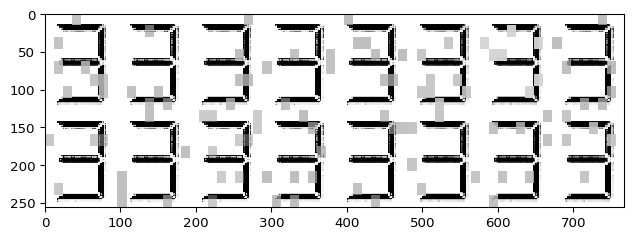

In [234]:
ia.seed(1)

# Example batch of images.
# The array has shape (8, 128, 128, 3) and dtype uint8.
images = np.array(
    [image for _ in range(16)],
    dtype=np.uint8
)
seq = iaa.Alpha(
    factor=(0.2, 0.8),
    first=iaa.Sharpen(1.0, lightness=2),
    second=iaa.CoarseDropout(p=0.1, size_px=8)
)

images_aug = seq.augment_images(images)
ia.imshow(ia.draw_grid(images_aug, cols=8, rows=2))

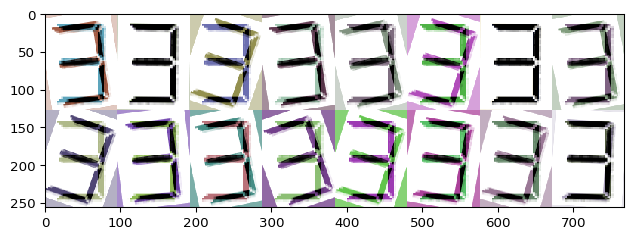

In [235]:
ia.seed(1)

seq = iaa.Alpha(
    factor=(0.2, 0.8),
    first=iaa.Affine(rotate=(-20, 20)),
    per_channel=True
)

images_aug = seq.augment_images(images)
ia.imshow(ia.draw_grid(images_aug, cols=8, rows=2))

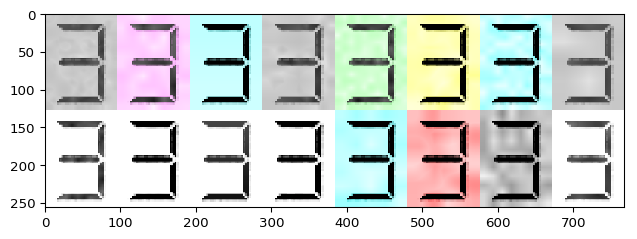

In [236]:
ia.seed(1)
seq = iaa.SimplexNoiseAlpha(
    first=iaa.Multiply(iap.Choice([0.5, 1.5]), per_channel=True)
)

images_aug = seq.augment_images(images)
ia.imshow(ia.draw_grid(images_aug, cols=8, rows=2))

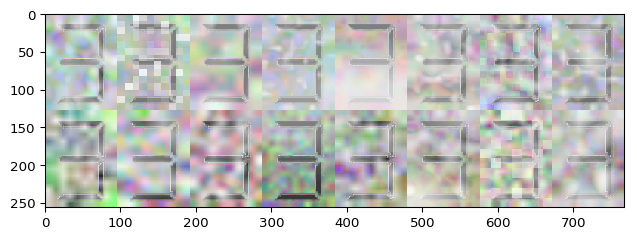

In [237]:
ia.seed(1)
seq = iaa.SimplexNoiseAlpha(
    first=iaa.EdgeDetect(1.0),
    per_channel=True
)

images_aug = seq.augment_images(images)
ia.imshow(ia.draw_grid(images_aug, cols=8, rows=2))


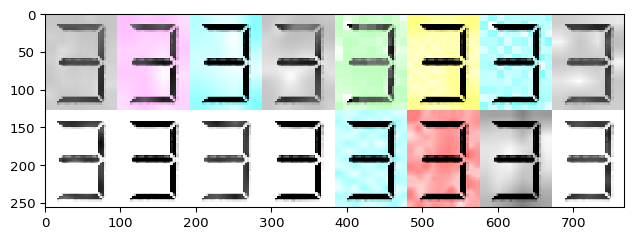

In [238]:
ia.seed(1)
seq = iaa.FrequencyNoiseAlpha(
    first=iaa.Multiply(iap.Choice([0.5, 1.5]), per_channel=True)
)

images_aug = seq.augment_images(images)
ia.imshow(ia.draw_grid(images_aug, cols=8, rows=2))

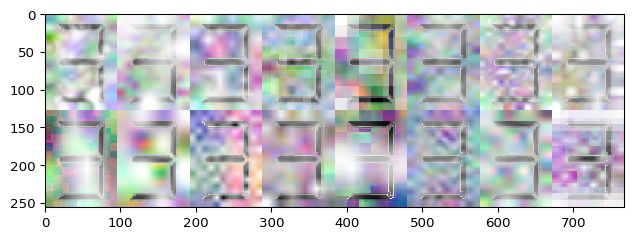

In [239]:
ia.seed(1)
seq = iaa.FrequencyNoiseAlpha(
    first=iaa.EdgeDetect(1.0),
    per_channel=True
)

images_aug = seq.augment_images(images)
ia.imshow(ia.draw_grid(images_aug, cols=8, rows=2))